In [1]:
import os
os.chdir("../")
print(os.getcwd())

/data1/xhuan192/codes/med-vlrm


In [2]:
import dotenv

dotenv.load_dotenv(override=True)
import json
import os
import string
from pathlib import Path

import click
import datasets
import pandas as pd
from datasets import ClassLabel, Dataset, DatasetDict, Features, Sequence, Value
from datasets import Image as ImageData
from PIL import Image
import base64
from io import BytesIO

import datasets
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import (
    AutoProcessor,
    AutoTokenizer,
    Qwen2_5_VLForConditionalGeneration,
)
from pprint import pprint, pformat
import matplotlib.pyplot as plt


/data1/xhuan192/misc/miniconda3/envs/m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_source = "med-vlrm/PMC-VQA-EasyR1"
dataset = datasets.load_dataset(data_source)
shuffle_seed = 42
num_proc = 16
dataset = dataset["train"]

In [4]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

def pil_to_base64_data_uri(img: Image.Image, format="JPEG"):
    buffer = BytesIO()
    img.save(buffer, format=format)
    img_bytes = buffer.getvalue()
    base64_str = base64.b64encode(img_bytes).decode("utf-8")
    return f"data:image/base64,{base64_str}"


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [5]:
# Print all special tokens and their IDs
for name, token in processor.tokenizer.special_tokens_map.items():
    pprint(f"{name}: {token} -> id: {processor.tokenizer.convert_tokens_to_ids(token)}")

'eos_token: <|im_end|> -> id: 151645'
'pad_token: <|endoftext|> -> id: 151643'
("additional_special_tokens: ['<|im_start|>', '<|im_end|>', "
 "'<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', "
 "'<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', "
 "'<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>'] -> id: "
 '[151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, '
 '151653, 151654, 151655, 151656]')


In [6]:
image_pad_token = "<|image_pad|>"
image_pad_token_id = processor.tokenizer.convert_tokens_to_ids(image_pad_token)
print(f"Image pad token id: {image_pad_token_id}")


Image pad token id: 151655


In [7]:
instruction_following = r"You will solve a problem/request. You should provide your thoughts within <think> </think> tags before providing the answer.\nWrite your final answer within <answer> </answer> tags. Here is the question:\n\n"

def tokenize_example(example, verbose=False):
    problem = example.pop("problem")
    prompt = problem + "\n\n" + instruction_following
    answer = example.pop("answer")
    # only a simple image
    image = example.pop("image")

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": pil_to_base64_data_uri(image),
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    if verbose:
        print(f"image shape: {image.size}")
        print(f"image inputs shape: {image_inputs[0].size}")
        print(f"inputs pixel shape: {inputs['pixel_values'].shape}")
    return inputs


In [8]:
inputs = tokenize_example(dataset[0], verbose=True)

image shape: (600, 598)
image inputs shape: (588, 588)
inputs pixel shape: torch.Size([1764, 1176])


In [9]:
input_ids = inputs["input_ids"]
detok_text = processor.tokenizer.decode(input_ids[0])
pprint(input_ids)
pprint(detok_text)

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151

In [10]:
image_pad_token = "<|image_pad|>"
image_pad_token_id = processor.tokenizer.convert_tokens_to_ids(image_pad_token)

input_ids = inputs["input_ids"]

num_total_tokens = input_ids[0].numel()
num_image_tokens = (input_ids[0] == image_pad_token_id).sum()
num_text_tokens = num_total_tokens - num_image_tokens
image_shape = inputs["pixel_values"].shape

print(f"Total tokens: {num_total_tokens}, Image tokens: {num_image_tokens}, Text tokens: {num_text_tokens}, image_shape: {image_shape}")

Total tokens: 549, Image tokens: 441, Text tokens: 108, image_shape: torch.Size([1764, 1176])


In [11]:
def stat_token_example(example):
    inputs = tokenize_example(example)
    input_ids = inputs["input_ids"]
    num_total_tokens = input_ids[0].numel()
    num_image_tokens = (input_ids[0] == image_pad_token_id).sum().item()
    num_text_tokens = num_total_tokens - num_image_tokens
    image_token_shape = inputs["pixel_values"].shape
    return {
        "num_total_tokens": num_total_tokens,
        "num_image_tokens": num_image_tokens,
        "num_text_tokens": num_text_tokens,
        "image_token_shape": image_token_shape,
    }

In [12]:
stat_token_example(dataset[0])

{'num_total_tokens': 549,
 'num_image_tokens': 441,
 'num_text_tokens': 108,
 'image_token_shape': torch.Size([1764, 1176])}

In [13]:
num_proc = 48
stat_token_dataset = dataset.map(
    stat_token_example,
    num_proc=num_proc,
    remove_columns=dataset.column_names,
    desc="Stat token example",
)

Stat token example (num_proc=48): 100%|██████████| 176917/176917 [05:15<00:00, 561.30 examples/s]


In [14]:
stat_token_df = stat_token_dataset.to_pandas()

In [ ]:
stat_token_df.sort_values("num_total_tokens")

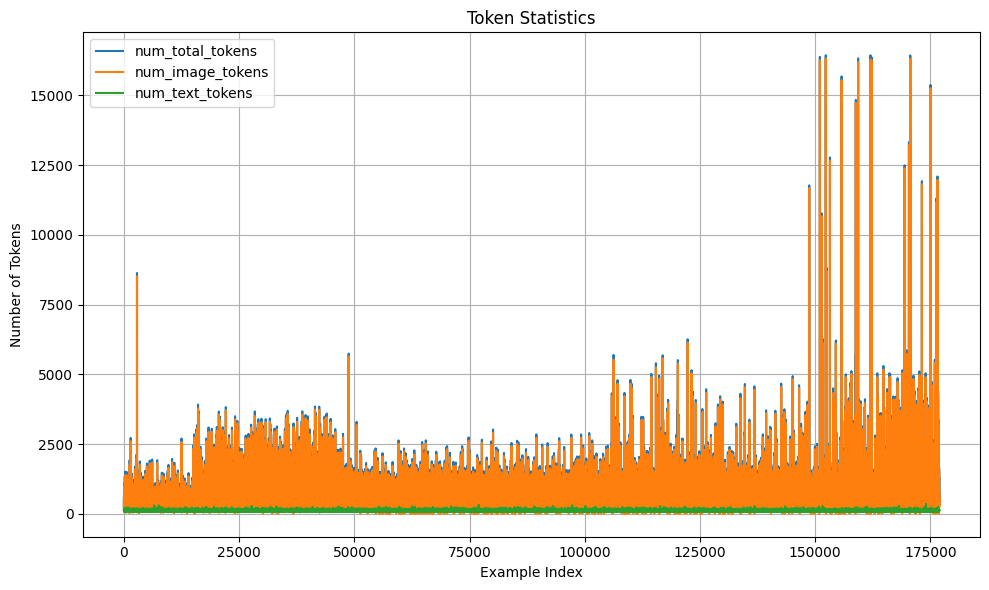

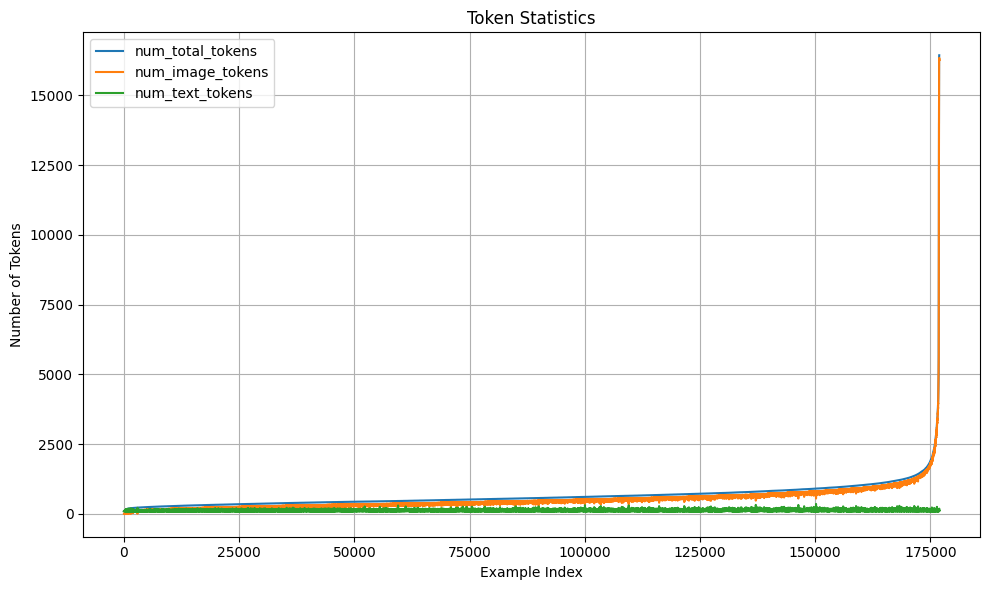

In [28]:
# plot line chart
fig, ax = plt.subplots(figsize=(10, 6))
stat_token_df.plot(
    y=["num_total_tokens", "num_image_tokens", "num_text_tokens"],
    kind="line",
    ax=ax,
    title="Token Statistics",
    xlabel="Example Index",
    ylabel="Number of Tokens",
    grid=True,
)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10, 6))
stat_token_df.sort_values("num_total_tokens").reset_index(drop=True).plot(
    y=["num_total_tokens", "num_image_tokens", "num_text_tokens"],
    kind="line",
    ax=ax,
    title="Token Statistics",
    xlabel="Example Index",
    ylabel="Number of Tokens",
    grid=True,
)
fig.tight_layout()

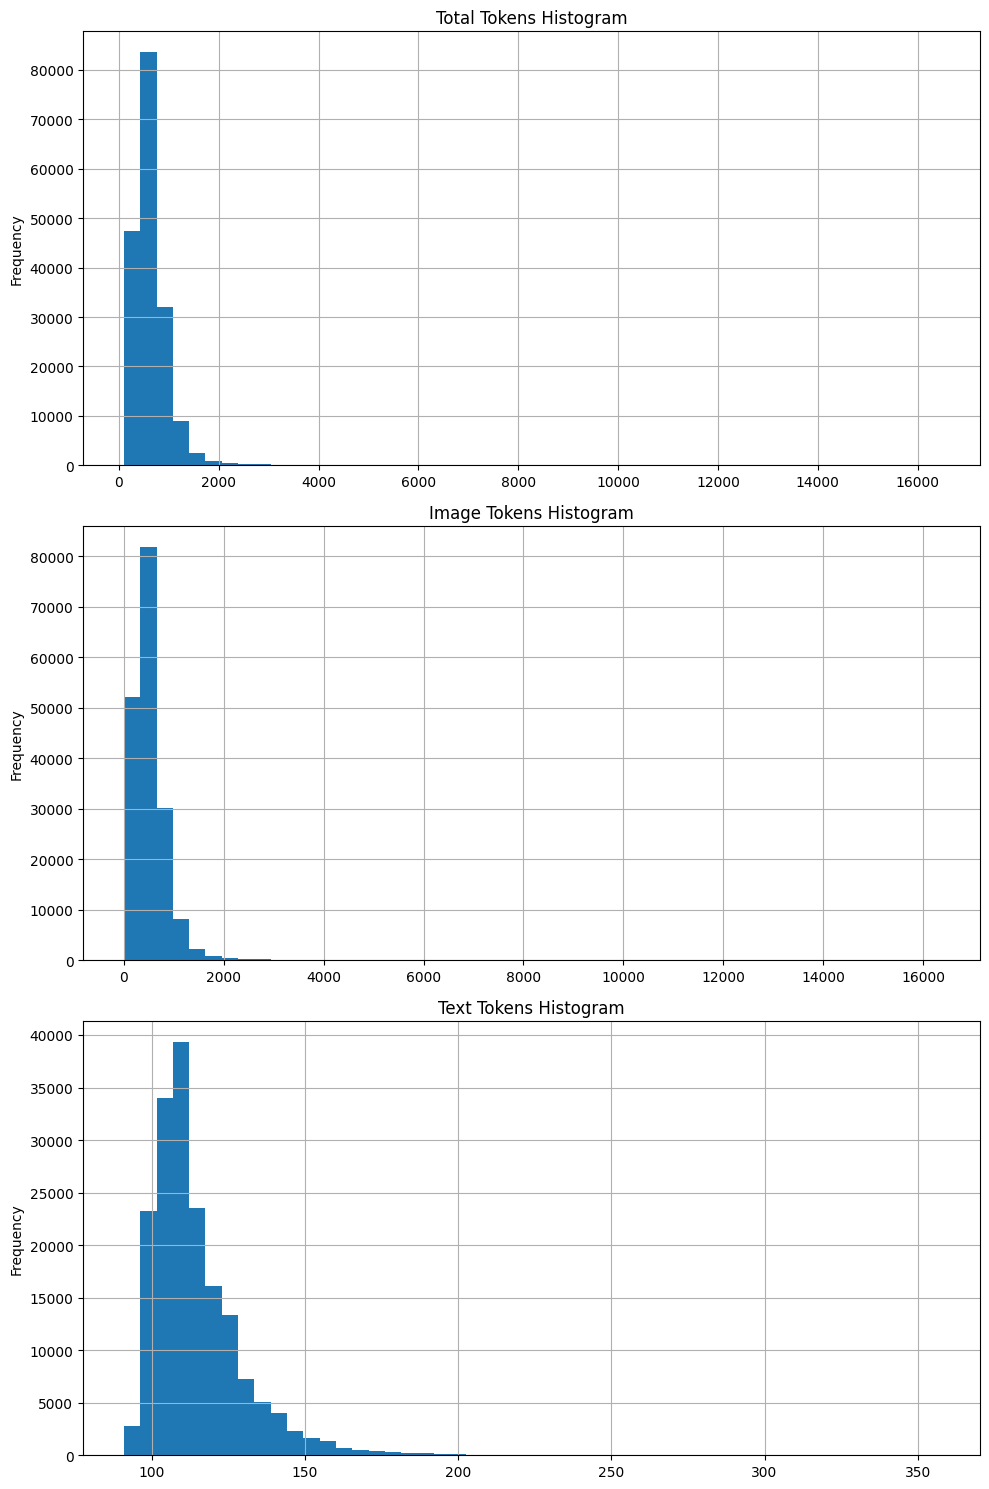

In [16]:
# plot hist for each column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
stat_token_df["num_total_tokens"].plot(
    kind="hist", ax=axes[0], title="Total Tokens Histogram", bins=50, grid=True
)
stat_token_df["num_image_tokens"].plot(
    kind="hist", ax=axes[1], title="Image Tokens Histogram", bins=50, grid=True
)
stat_token_df["num_text_tokens"].plot(
    kind="hist", ax=axes[2], title="Text Tokens Histogram", bins=50, grid=True
)
fig.tight_layout()


In [17]:
# stat_token_df["num_total_tokens"] > 2000, the percentage
total_examples = len(stat_token_df)
over_2000_tokens = stat_token_df[stat_token_df["num_total_tokens"] > 2000].shape[0]
percentage_over_2000 = (over_2000_tokens / total_examples) * 100
print(f"Percentage of examples with more than 2000 tokens: {percentage_over_2000:.2f}%, Total examples: {total_examples}, Over 2000 tokens: {over_2000_tokens}")

Percentage of examples with more than 2000 tokens: 0.93%, Total examples: 176917, Over 2000 tokens: 1650


In [18]:
display(stat_token_df.sort_values("num_image_tokens"))
display(stat_token_df[stat_token_df["num_total_tokens"] > 2000].sort_values("num_image_tokens"))

,num_total_tokens,num_image_tokens,num_text_tokens,image_token_shape
149903,120,4,116,"[16, 1176]"
79860,117,4,113,"[16, 1176]"
75233,118,4,114,"[16, 1176]"
75232,114,4,110,"[16, 1176]"
79859,116,4,112,"[16, 1176]"
...,...,...,...,...
170622,16404,16290,114,"[65160, 1176]"
170623,16397,16290,107,"[65160, 1176]"
170624,16406,16290,116,"[65160, 1176]"
170637,16423,16303,120,"[65212, 1176]"


,num_total_tokens,num_image_tokens,num_text_tokens,image_token_shape
118696,2016,1785,231,"[7140, 1176]"
37307,2005,1869,136,"[7476, 1176]"
29241,2005,1869,136,"[7476, 1176]"
25918,2012,1876,136,"[7504, 1176]"
46877,2012,1876,136,"[7504, 1176]"
...,...,...,...,...
170624,16406,16290,116,"[65160, 1176]"
170623,16397,16290,107,"[65160, 1176]"
170621,16428,16290,138,"[65160, 1176]"
170637,16423,16303,120,"[65212, 1176]"


In [19]:
sample_id = 149903
sample = dataset[sample_id]
image = sample['image']
display(image)
display(image.size)
display(sample)

(17, 17)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=17x17>,
 'problem': '<image>What is shown in Figure (b)?\n\nA: Tip position in E3-axis direction.\n\nB: Tip position in E1-axis direction.\n\nC: Error in E3-axis direction.\n\nD: Error in E1-axis direction.',
 'answer': 'B'}

In [20]:
sample_id = 118696
sample = dataset[sample_id]
image = sample['image']
# display(image)
display(image.size)
display(sample)
inputs = tokenize_example(sample, verbose=True)

sample = dataset[sample_id]
display(stat_token_example(sample))

(1417, 991)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1417x991>,
 'problem': '<image>What does the fMRI image during reaching task (left arm) in participant #1 show?\n\nA: Brain activation in the left primary motor and sensory cortex, posterior parietal cortex, prefrontal cortex, and right cerebellum (p\u2009<\u20090.001).\n\nB: No brain activation in any area (p\u2009<\u20090.001).\n\nC: Brain activation in the right primary motor and sensory cortex, posterior parietal cortex, prefrontal cortex, and left cerebellum (p\u2009<\u20090.001).\n\nD: Brain activation in the left primary motor and sensory cortex, posterior parietal cortex, and prefrontal cortex (p\u2009<\u20090.001).',
 'answer': 'C'}

image shape: (1417, 991)
image inputs shape: (1428, 980)
inputs pixel shape: torch.Size([7140, 1176])


{'num_total_tokens': 2016,
 'num_image_tokens': 1785,
 'num_text_tokens': 231,
 'image_token_shape': torch.Size([7140, 1176])}

In [30]:
sample_id = 152295
sample = dataset[sample_id]
image = sample['image']
# display(image)

# resize the longest dim to 384
def resize_longest_dim(image, target_size=384):
    width, height = image.size
    if width > height:
        new_width = target_size
        new_height = int(height * (target_size / width))
    else:
        new_height = target_size
        new_width = int(width * (target_size / height))
    return image.resize((new_width, new_height), Image.BILINEAR)

resized_image = resize_longest_dim(image, target_size=1200)
# display(resized_image)
print(f"Resized image size: {resized_image.size}")


Resized image size: (1060, 1200)


In [22]:
new_sample = {k:v for k,v in sample.items() if k != 'image'}

resized_image = resize_longest_dim(image, target_size=1200)
new_sample['image'] = resized_image

display(new_sample)
tokenize_example(new_sample.copy(), verbose=True)
display(stat_token_example(new_sample.copy()))

{'problem': '<image>What does the blue squares on the graph represent?\n\nA: Levels of carcinoembryonic antigen (CEA)\n\nB: The sum of target lesions\n\nC: RET molecular profiles\n\nD: Time during treatment',
 'answer': 'B',
 'image': <PIL.Image.Image image mode=RGB size=1060x1200>}

image shape: (1060, 1200)
image inputs shape: (1064, 1204)
inputs pixel shape: torch.Size([6536, 1176])


{'num_total_tokens': 1748,
 'num_image_tokens': 1634,
 'num_text_tokens': 114,
 'image_token_shape': torch.Size([6536, 1176])}